# 30cappa con meno di 5mila abitanti

![](https://raw.githubusercontent.com/aborruso/30cappa/main/risorse/2020-12-18_slide_Natale.png)

- trovare i piccoli Comuni (fino a 5mila abitanti)
- calcolare i 30kmdal confine  da cui possono spostare
- impedendo di andare nei Comuni capoluogo di Provincia

## Setup

queste istruzoni possono essere commentate

In [ ]:
!pip install requests

In [ ]:
!pip install matplotlib

In [ ]:
!pip install pandas

In [ ]:
!pip install geopandas

In [ ]:
!pip install pygeos

In [ ]:
# giusto per aggiungere una mappa in background
!pip install contextily

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import requests, zipfile, io
import matplotlib.pyplot as plt
import contextily as ctx

# Raccolta dei dati
- confini comunali
- statistiche popolazione

## Confini dei comuni d'Italia

ISTAT offre gli shapefile delle unità amministrative
https://www.istat.it/it/archivio/222527

Ciascun archivio è un file zip che contiene diverse unità amministrative: macroregioni, regioni, province e comuni.
Alcuni campi significativi:
- PRO_COM_T è il codice univoco per ogni comune assegnato da ISTAT
- *CC_UTS* quando il valore è uguale a 1 significa che si tratta di un comune capoluogo di provincia
- *COD_REG* è il codice univoco della regione assegnato da ISTAT

**NOTE**<br/>
- le geometrie dei confini comunali sono archiviate con proiezione [WGS 84 / UTM zone 32N](https://epsg.io/32632), quindi in metri
- molti comuni hanno [enclave ed exclave](https://it.wikipedia.org/wiki/Enclave_ed_exclave) con il risultato che il confine comunale è composto da aree non contigue fra di loro
- un caso particolare è il comune di [Campione d'Italia](https://it.wikipedia.org/wiki/Campione_d%27Italia) che è al di fuori dal confine italiano
- le province autonome di Trento e Bolzano, in questo caso, vanno considerate come regioni, quindi bisogna guardare anche il valore *COD_PROV*.la Regione Trentino Alto Adige ha COD_REG con valore 4, la provincia di Bolzano ha valore COD_PROV=21 mentre Trento COD_PROV=22


**download dei dati**

In [10]:
# indirizzo del file
zip_file_url = 'https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012020.zip'
#download
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
#decompressione
z.extractall()

**geodataframe con i limiti comunali**

In [11]:
limiti_comuni = gpd.read_file("Limiti01012020" + os.sep + "Com01012020" + os.sep + "Com01012020_WGS84.shp",encoding='utf-8')

ed ecco la mappa dei comuni d'Italia

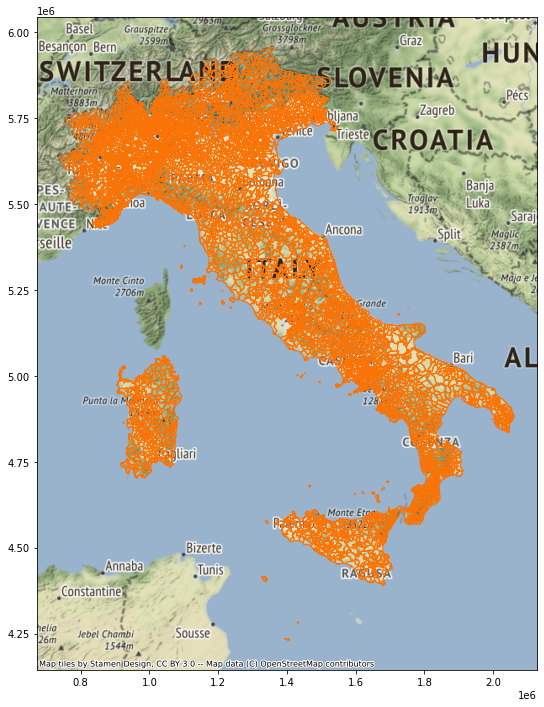

In [12]:
ax = limiti_comuni.to_crs(epsg=3857).plot(figsize=(12,12),edgecolor='xkcd:orange',facecolor="none")
ctx.add_basemap(ax,crs=limiti_comuni.to_crs(epsg=3857).crs.to_string(),source=ctx.providers.Stamen.Terrain)

**creazione del confine nazionale**
questo servirà per tagliare le aree all'interno del confine nazionale.<br/>
Per creare il confine partiamo dal file con le macroregioni d'Italia solo per questioni di performance

In [13]:
macroregioni_italiane = gpd.read_file("Limiti01012020" + os.sep + "RipGeo01012020" + os.sep + "RipGeo01012020_WGS84.shp",encoding='utf-8')

questa la mappa delle macroregioni (DEN_RIP contiene il nome)

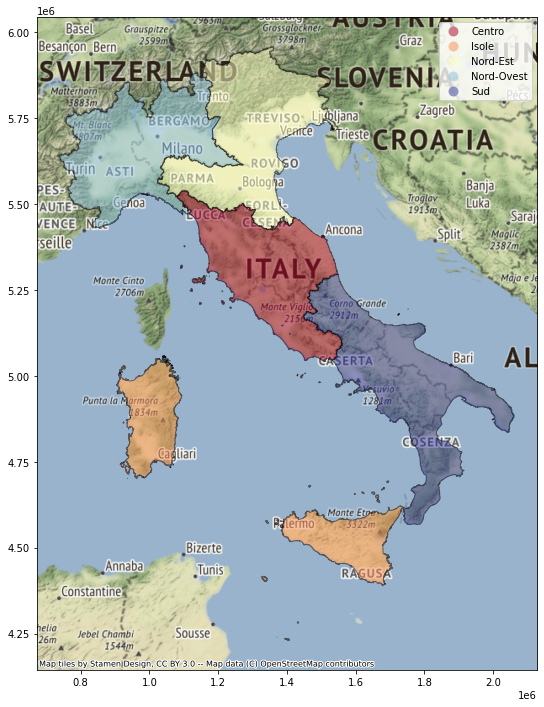

In [14]:
ax = macroregioni_italiane.to_crs(epsg=3857).plot(column='DEN_RIP',figsize=(12,12),alpha=0.5,edgecolor="black",cmap="RdYlBu",legend=True)
ctx.add_basemap(ax,crs=limiti_comuni.to_crs(epsg=3857).crs.to_string(),source=ctx.providers.Stamen.Terrain)

creiamo un campo per creare la dissolvenza ( = unire tutti i poligoni con lo stesso valore)

In [15]:
macroregioni_italiane['nazione']='Italia'

In [16]:
confini_italia = macroregioni_italiane[['nazione', 'geometry']]

... ed ora procediamo con la dissolvenza

In [17]:
confini_italia = confini_italia.dissolve(by='nazione')

ed ora vediamo la mappa

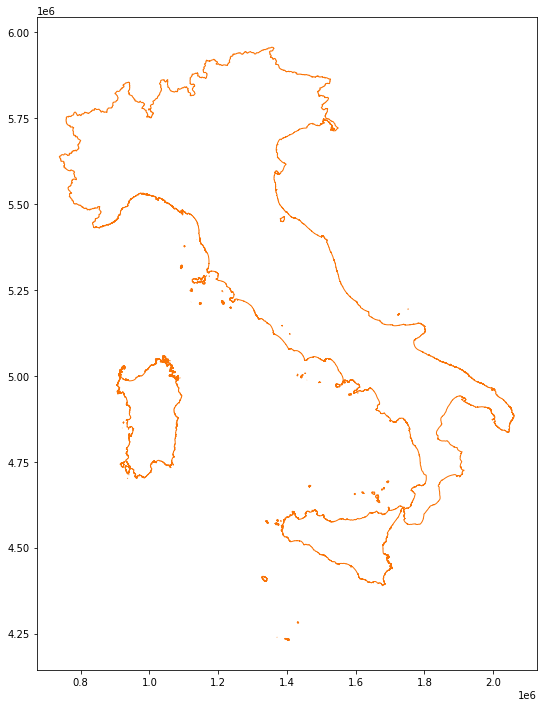

In [18]:
ax = confini_italia.to_crs(epsg=3857).plot(figsize=(12,12),edgecolor='xkcd:orange',facecolor="none")

**ottenere l'elenco dei capoluoghi di provincia**

CC_UTS = 1

In [19]:
comuni_capoluoogo_provincia = limiti_comuni[limiti_comuni.CC_UTS == 1][['COMUNE','PRO_COM_T']]

In [20]:
# visualizzare i primi 5
comuni_capoluoogo_provincia.head(5)

,COMUNE,PRO_COM_T
175,Vercelli,002158
474,Avellino,064008
521,Massa,045010
604,Milano,015146
644,Cuneo,004078


export della tabella in formato csv

In [21]:
comuni_capoluoogo_provincia.to_csv("comuni_capoluoogo_provincia.csv")

## Informazioni statistiche sulla popolazione in Italia

ISTAT offre il sito https://demo.istat.it che rilascia dati aggiornati con cadenza periodica.

L'ultimo elenco disponibile è quello di gennaio 2020

Il file con i dati per comune si trova qui http://demo.istat.it/pop2020/dati/comuni.zip

In [22]:
dati_demografici_comuni_italiani = "http://demo.istat.it/pop2020/dati/comuni.zip"

nonostante lo zip contenga un CSV la prima riga va cancellata in quanto è usata come titolo del dataset, pertanto bisogna partire dalla seconda (*skiprows=1*).<br/>
La codifica caratteri è *utf-8*

In [23]:
demo_comuni = pd.read_csv(dati_demografici_comuni_italiani,skiprows=1,encoding='utf-8',low_memory=False)

visualizzazione prime righe

In [25]:
demo_comuni.head(5)

,Codice comune,Denominazione,Età,Maschi celibi,Maschi coniugati,Maschi divorziati,Maschi vedovi,Maschi uniti civilmente,Maschi già in unione civile (per scioglimento),Maschi già in unione civile (per decesso del partner),Totale Maschi,Femmine nubili,Femmine coniugate,Femmine divorziate,Femmine vedove,Femmine unite civilmente,Femmine già in unione civile (per scioglimento),Femmine già in unione civile (per decesso del partner),Totale Femmine
0,1001,Agliè,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,5.0,11.0,0.0,0.0,0.0,NaN,NaN,NaN,11.0
1,1001,Agliè,1.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,9.0,15.0,0.0,0.0,0.0,NaN,NaN,NaN,15.0
2,1001,Agliè,2.0,6.0,0.0,0.0,0.0,NaN,NaN,NaN,6.0,8.0,0.0,0.0,0.0,NaN,NaN,NaN,8.0
3,1001,Agliè,3.0,7.0,0.0,0.0,0.0,NaN,NaN,NaN,7.0,11.0,0.0,0.0,0.0,NaN,NaN,NaN,11.0
4,1001,Agliè,4.0,13.0,0.0,0.0,0.0,NaN,NaN,NaN,13.0,15.0,0.0,0.0,0.0,NaN,NaN,NaN,15.0


**note**<br/>
ogni riga è organizzata per fasce d'età (campo *Età*), il valore *999* contiene il totale.<br/>
Occorre quindi filtrare il csv per il valore *999*


quindi è necessario filtrare per quel valore

In [26]:
comuni_popolazione = demo_comuni[demo_comuni.Età == 999]

per calcolare il totale della popolazione è necessario sommare *Totale Femmine* con *Totale Maschi*

In [ ]:
comuni_popolazione['POPOLAZIONE'] = comuni_popolazione.loc[:, ('Totale Femmine', 'Totale Maschi')].sum(axis=1)

dalla tabella creata prendiamo solo le colonne utili


In [29]:
comuni_popolazione = comuni_popolazione[['Codice comune','Denominazione','POPOLAZIONE']]

per comodità nelle operazioni successive conviene rinominare le colonne allo stesso modo di quelle del file con i confini comunali

In [30]:
comuni_popolazione.rename(columns={'Codice comune':'PRO_COM_T','Denominazione':'COMUNE'}, inplace=True)

**elenco dei 'piccoli Comuni'**

la definizione dice "fino a 5000 abitanti" 

In [31]:
piccoli_comuni = comuni_popolazione[comuni_popolazione.POPOLAZIONE <= 5000]

vediamo quanti sono

In [32]:
piccoli_comuni.shape[0]

5521

esportazione del file in formato .csv

In [33]:
piccoli_comuni.to_csv("piccoli_comuni.csv")

*nota*<br/>
Quanti sono i comuni fra i 5001 e 5020 abitanti?


In [34]:
comuni5001_5020 = comuni_popolazione[(comuni_popolazione.POPOLAZIONE >= 5001) & (comuni_popolazione.POPOLAZIONE <= 5020)]


quanti sono i comuni in questione

In [35]:
comuni5001_5020.shape[0]

6

quali sono in ordine crescente di popolazione

In [36]:
comuni5001_5020.sort_values('POPOLAZIONE')

,PRO_COM_T,COMUNE,POPOLAZIONE
91493,6053,Castelnuovo Scrivia,5001.0
273971,21038,Lagundo,5003.0
184619,15200,Santo Stefano Ticino,5006.0
411161,42008,Castelbellino,5010.0
544781,65055,Giffoni Sei Casali,5015.0
208181,16212,Telgate,5020.0


## trovare l'area a 30km di raggio dal confine dei piccoli comuni

operazioni da svolgere:
- aggiungere ai dati dei confini comunali l'attributo della popolazione per ciascun comune
- l'area a 30cappa si calcola usando la funzione [buffer](https://geopandas.org/geometric_manipulations.html#GeoSeries.buffer)
- a questa va sottratta dei confini nazionali 

come output generiamo un file geojson per ogni comune e associamo anche la lista dei comuni a 30km di distanza nel campo *comunia30cappa*

estendere alle geometrie il valore della popolazione

In [37]:
comuni_popolazione_tojoin = comuni_popolazione[['PRO_COM_T','POPOLAZIONE']]

per fare la join è necessario che entrambi i campi abbiano gli stessi valori.<br/> 
il codice ISTAT dei comuni è fatto da sei cifre ed è composto dal codice provincia più un numero sequenziale dei comuni presenti.<br/>
Per renderlo di 6 cifre si aggiungo tanti zero quanti necessari (funzione *zfill* di python)

In [ ]:
comuni_popolazione_tojoin['PRO_COM_T'] = comuni_popolazione_tojoin['PRO_COM_T'].apply(lambda k: str(k).zfill(6))

In [47]:
geo_comuni_popolazione = limiti_comuni.merge(comuni_popolazione_tojoin,on='PRO_COM_T')

**comuni fino a 5000 abitanti e i loro confini**

In [50]:
geo_piccoli_comuni = geo_comuni_popolazione[geo_comuni_popolazione.POPOLAZIONE <= 5000]

In [51]:
geo_piccoli_comuni.shape

(5508, 15)

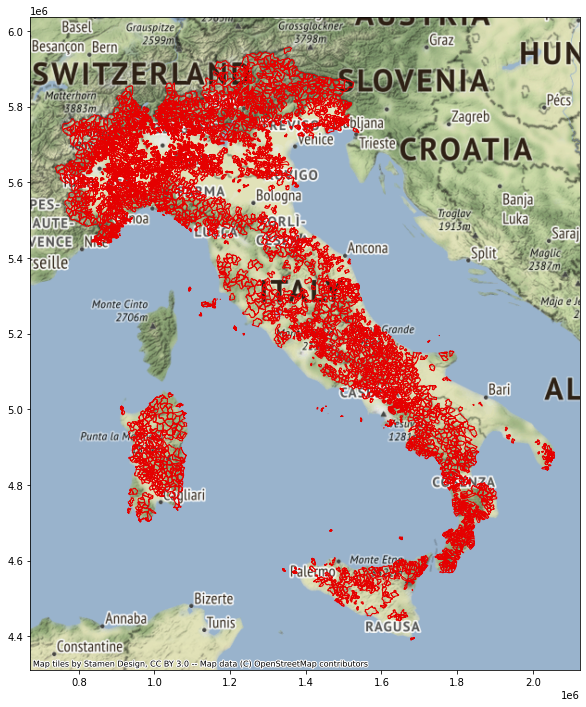

In [52]:
ax = geo_piccoli_comuni.to_crs(epsg=3857).plot(figsize=(12,12),edgecolor='xkcd:red',facecolor="none")
ctx.add_basemap(ax,crs=geo_piccoli_comuni.to_crs(epsg=3857).crs.to_string(),source=ctx.providers.Stamen.Terrain)

**inizio del calcolo**

a causa del fatto che bisogna prendere in considerazione il confine regionale andiamo a fare il calcolo dei comuni per ogni regione (o provincia autonoma)

La fuzione *area30Cappa* si occupa di calcolare l'area di un singolo comune a 30km dal confine


In [53]:
def area30Cappa(comune,comuni_capoluogo,confine):
  # creazione dell'area a 30cappa dal confine
  comune['geometry'] = comune.geometry.buffer(30000)
  # taglio sul confine regionale
  comune = gpd.overlay(comune,confine, how='intersection')
  # spatial join al fine di avere i nomi dei comuni che intersecano l'area
  # nota: l'intersezione aggiunge i suffissi _right
  comuni_raggiungibili = gpd.sjoin(comune,comuni_capoluogo)[['COMUNE_right','PRO_COM_T_right','CC_UTS']]
  # pulizia del suffisso
  for col in comuni_raggiungibili.columns:
    comuni_raggiungibili.rename(columns={col:col.replace("_right","")},inplace=True)
  # esclusione dell'aree dei comuni capoluogo
  capoluoghi = []
  for cod_capoluogo in comuni_raggiungibili[comuni_raggiungibili.CC_UTS==1].PRO_COM_T.unique():
    capoluogo = comuni_capoluogo[comuni_capoluogo.PRO_COM_T == cod_capoluogo].reset_index()
    capoluoghi.append(capoluogo.COMUNE.values[0])
    # creazione della nuova geometria
    comune = gpd.overlay(comune,capoluogo,how='difference')
  comuni_30cappa = ""
  lista_comuni = list(comuni_raggiungibili.COMUNE.unique())
  for ncapoluogo in capoluoghi:
    lista_comuni.remove(ncapoluogo)
  for nome in lista_comuni:
      comuni_30cappa += nome + " ,"
  comuni_30cappa = comuni_30cappa.lstrip(" ,")
  # aggiunta dell'elenco dei comuni raggiungibili
  comune['30CAPPA'] = comuni_30cappa
  # selezione dei campi utili allo scopo
  comune = comune[['COMUNE','PRO_COM_T','POPOLAZIONE','30CAPPA','geometry']]
  return(comune)

... e qui comincia il ciclo

In [ ]:
tutti_i_comuni = []
# estrazione comuni capoluogo 
geo_comuni_capoluoogo_provincia = geo_comuni_popolazione[geo_comuni_popolazione.CC_UTS == 1]
for codice in geo_piccoli_comuni.PRO_COM_T.unique():
  # estrazione singolo comune
  comune = geo_piccoli_comuni[geo_piccoli_comuni['PRO_COM_T'] == codice].reset_index()
  comune = comune[['COMUNE','PRO_COM_T','POPOLAZIONE','geometry']]
  nome = str(comune['PRO_COM_T'].values[0])
  comune.to_crs(epsg=4326).to_file(nome + ".geojson",driver="GeoJSON")
  comune = area30Cappa(comune,geo_comuni_capoluoogo_provincia,confini_italia)
  ## creazione del file geojson
  comune.to_crs(epsg=4326).to_file(nome + "_a30cappa.geojson",driver="GeoJSON")
  tutti_i_comuni.append(comune)

giusto per curiosità creiamo la mappa dell'ultimo comune processato

In [ ]:
ax = comune.to_crs(epsg=3857).plot(figsize=(12,12),edgecolor='xkcd:orange',facecolor="xkcd:orange",alpha=0.5)
ctx.add_basemap(ax,crs=comune.to_crs(epsg=3857).crs.to_string(),source=ctx.providers.Stamen.Terrain)

**creazione del layer con tutti i dati calcolati**



In [ ]:
finoa5mila30cappa = gpd.GeoDataFrame( pd.concat( tutti_i_comuni, ignore_index=True) )

il file creato è un geojson dal nome finoa5mila30cappa.geojson

In [ ]:
finoa5mila30cappa.to_crs(epsg=4326).to_file('finoa5mila30cappa.geojson',driver="GeoJSON")

e qui la mappa di tutti i comuni messi insieme

In [ ]:
ax = finoa5mila30cappa.to_crs(epsg=3857).plot(figsize=(12,12),edgecolor='xkcd:orange',facecolor="none")
ctx.add_basemap(ax,crs=finoa5mila30cappa.to_crs(epsg=3857).crs.to_string(),source=ctx.providers.Stamen.Terrain)